# Static Structure Factor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pimcscripts import pimchelp
from collections import defaultdict
from lmfit import Model, Parameters

import importlib

from dgutils import colors as colortools
import dgutils

%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'sans':'../include/sans.mplstyle', 'notebook':'../include/notebook.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['notebook'])

figsize = plt.rcParams['figure.figsize']

π = np.pi
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import poreutils as pore
importlib.reload(pore)

from poreutils import red,orange,green,lblue,blue,dblue,purple
from poreutils import pore_colors,pore_labels,font_path,reduced_data_path

core_color = purple

## For now, we have a hard-coded list of pimcids

In [3]:
pimcids = ['2c9b0db6-271f-467f-803c-070arcut15g2','5c1d4ac3-caf0-48ea-b04f-f19crcut15g2',
           '32363073-f6d3-428a-a335-58d7rcut15g2','7bd42668-4043-461d-9cb7-514frcut15g2']

core_pimcid = 'a5835329-03fa-4eee-8ab7-6cfrcut1p7g2'

μ = [-47.0,-27.0,-19.0,-7.0]

In [4]:
reduce = False
data_dir = '../data/QMC/PCF/'

In [5]:
def key(par_map):
    if par_map['Ensemble'] == 'grand canonical':
        return f"μ = {par_map['Chemical Potential']} K"
    else:
        return f"N = {par_map['Initial Number Particles']}"
    
def get_data(pimcids, data_dir, canonical=False, perform_reduce=False, cylinder=False):
    
    _data = defaultdict(dict)
    par_map = defaultdict(dict)
    
    #reduced_dir = reduced_data_path
    reduced_dir = data_dir
    if cylinder:
        data_dir += 'CYLINDER/'
        reduced_dir += 'CYLINDER/'
            
    for i,pimcid in enumerate(pimcids):
    
        log_name = pimchelp.get_file_list_from_params(canonical=canonical, pimcid=pimcid,base_dir=data_dir)
        par = pimchelp.get_parameter_map(data_dir + log_name)
        par_map[pimcid] = par

        sim_params = {'τ':par['Specified Imaginary Time Step'], 'μ':par['Chemical Potential'], 'L':par['Container Dimensions'][-1], 
                      'pimcid':pimcid, 'canonical':par['Ensemble']=='canonical'}
        if perform_reduce:
            if par['Ensemble'] == 'canonical':
                !reduce-one.py -r T --canonical -L {sim_params['L']}  -t {sim_params['τ']} -i {sim_params['pimcid']} {data_dir}
            else:
                !reduce-one.py -r T -L {sim_params['L']} -u {sim_params['μ']} -t {sim_params['τ']} -i {sim_params['pimcid']} {data_dir}

        try:
            est = pimchelp.PIMCResults(f"{reduced_dir}{pimchelp.get_reduce_name(**sim_params,reduce='T', estimator='estimator')}")
            _data['est'][key(par)] = est.data
        except:
            print('no estimator found')
            pass

        try:
            g2_est = pimchelp.PIMCResults(f"{reduced_dir}{pimchelp.get_reduce_name(**sim_params,reduce='T', estimator='pair')}")
            _data['g2'][key(par)] = g2_est.epdata(g2_est.params[0])

        except:
            print('no pair correlation function found')

            pass    
        try:
            S_est = pimchelp.PIMCResults(f"{reduced_dir}{pimchelp.get_reduce_name(**sim_params,reduce='T', estimator='ssf')}")
            _data['S'][key(par)] = S_est.epdata(S_est.params[0])

        except:
            print('no static structure factor found')
            pass
        
        try:
            Sq_est = pimchelp.PIMCResults(f"{reduced_dir}{pimchelp.get_reduce_name(**sim_params,reduce='T', estimator='ssfq')}")
            _data['Sq'][key(par)] = Sq_est.epdata(Sq_est.params[0])
        except:
            print('no q-static structure factor found')
            pass
        
    return _data,par_map

In [6]:
data,par_map = get_data(pimcids, data_dir,perform_reduce=reduce)
data_1d,par_map_1d = get_data([core_pimcid], data_dir,cylinder=True,perform_reduce=reduce)
data_cyl,par_map_cyl = get_data(pimcids, data_dir, cylinder=True,perform_reduce=reduce)

no static structure factor found
no q-static structure factor found
no static structure factor found
no q-static structure factor found
no static structure factor found
no q-static structure factor found
no static structure factor found
no q-static structure factor found
no q-static structure factor found
no static structure factor found
no q-static structure factor found
no static structure factor found
no q-static structure factor found
no static structure factor found
no q-static structure factor found
no static structure factor found
no q-static structure factor found


## Pair Correlation Function

### Central Core

0.29287303600000003


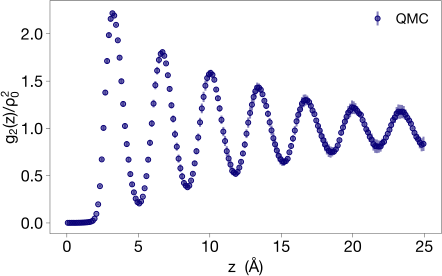

In [7]:
L = par_map_1d[core_pimcid]['Container Dimensions'][-1]
T = par_map_1d[core_pimcid]['Temperature']
ρ0 = data_1d['est']['μ = -7.0 K']['N']/L
r_core,g2_core,Δg2_core = data_1d['g2']['μ = -7.0 K']
Δr_core = r_core[2]-r_core[1]
ρ1D = data_1d['est']['μ = -7.0 K']['N']/L
print(ρ1D)

plt.errorbar(r_core+Δr_core/2,g2_core, yerr=Δg2_core, **pore.get_props(core_color), label='QMC')

plt.xlabel('z  (Å)')
plt.ylabel(r'$g_2(z)/\rho_0^2$')
plt.legend();

### Fitting to Luttinger Liquid Theory

There are there levels of approximation depending on what assumptions we make (and which are valid).  In the limit $T \to 0$ and $L \to \infty$ we have:

\begin{equation}
\langle\rho(z) \rho(0)\rangle \rightarrow \rho_{0}^{2}-\frac{K}{2 \pi^{2} z^{2}}+\frac{\mathcal{A}}{z^{2K }} \cos \left(2 \pi \rho_{0} z\right).
\end{equation}

The next approximation is to assume we are at low temperature, i.e. $ T \ll \hbar v / k_{\rm B} L$. Then, Cazalilla has the result for periodic boundary conditions:

\begin{equation}
\langle\rho(z) \rho(0)\rangle  \simeq \rho_{0}^{2}\left\{1-\frac{K}{2 \pi^{2}}\left[\frac{1}{\rho_{0} d(z \mid L)}\right]^{2}+ \mathcal{A} \left[\frac{1}{\rho_{0} d(z \mid L)}\right]^{2 K} \cos \left(2 \pi m \rho_{0} z\right)\right\}
\end{equation}

where the *chord length* is given by:

\begin{equation}
d(z\mid L) = \frac{L}{\pi} \left \lvert \sin \frac{\pi z}{L} \right \rvert\, .
\end{equation}

Finally, we have at finite temperture and finite length:

\begin{equation}
\langle\rho(z) \rho(0)\rangle=  \rho_{0}^{2}+\frac{K}{2 \pi^{2}} \frac{d^{2}}{d z^{2}} \ln \theta_{1}\left[\frac{\pi z}{L}, e^{-\pi v / L T}\right] 
+\mathcal{A} \cos \left(2 \pi \rho_{0} z\right)\left\{\frac{2 \eta\left(\frac{i v}{L T}\right) e^{-\pi v / 6 L T}}{\theta_{1}\left(\frac{\pi z}{L}, e^{-\pi v / L T}\right)}\right\}^{2 K}
\end{equation}

where $\eta(\cdot)$ is the Dedekind eta function and $\theta_1(z,q)$ is the Jacobi theta function of the first kind.  

In all cases, it is beneficial to only perform a least-squares fit to the envelope.  We will perform the simplest fit to the $L\to\infty, T\to0$ form.

### Extract the extrema

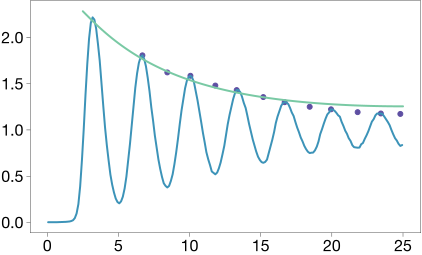

In [8]:
from scipy.signal import argrelextrema
max_idx = argrelextrema(g2_core, np.greater,order=2)[0]
x_max= r_core[max_idx][1:] + Δr_core/2
y_max= g2_core[max_idx][1:]-1
Δy_max= Δg2_core[max_idx][1:]

min_idx = argrelextrema(g2_core, np.less,order=2)[0]
x_min = r_core[min_idx][3:] + Δr_core/2
y_min = -g2_core[min_idx][3:]+1
Δy_min = Δg2_core[min_idx][3:]

x = np.concatenate((x_min,x_max))
sort_idx = np.argsort(x)

x = x[sort_idx]
z_start = x[0]

y = np.concatenate((y_min,y_max))[sort_idx]+1
Δy = np.concatenate((Δy_min,Δy_max))[sort_idx]

plt.plot(x,y,'o')
plt.plot(r_core+Δr_core/2,g2_core)

_z = np.linspace(2.5,25,100)
plt.plot(_z,pore.g2_LL_TL_max(_z,ρ0,L,T,0.18,11,0.035,1))
#plt.plot(_z,pore.g2_LL_T0Linf_max(_z,ρ0,0.18,0.1,1))

[[Model]]
    Model(g2_LL_TL_max)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 12
    # variables        = 3
    chi-square         = 7.43655458
    reduced chi-square = 0.82628384
    Akaike info crit   = 0.25801197
    Bayesian info crit = 1.71273192
[[Variables]]
    ρo:    0.292873 (fixed)
    L:     50 (fixed)
    T:     1.6 (fixed)
    K:     0.15128400 +/- 0.03518761 (23.26%) (init = 0.15)
    v:     7.90304418 +/- 2.55764370 (32.36%) (init = 11.2)
    A:     0.03630145 +/- 0.00240228 (6.62%) (init = 0.05)
    sign:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(K, v) =  0.963
    C(K, A) = -0.957
    C(v, A) = -0.883


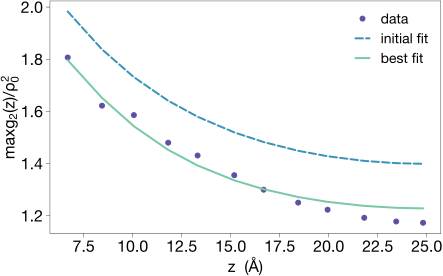

In [9]:
# We get only the extrema of the pair correlation function
# from scipy.signal import argrelextrema
#max_idx = argrelextrema(g2_core, np.greater)[0]
#x = r[max_idx][1:] + Δr/2
#y = g2_core[max_idx][1:]
#Δy = Δg2_core[max_idx][1:]

fit_model_max = {'T0Linf':pore.g2_LL_T0Linf_max, 'T0L':pore.g2_LL_T0L_max, 'TL':pore.g2_LL_TL_max}
fit_model = {'T0Linf':pore.g2_LL_T0Linf, 'T0L':pore.g2_LL_T0L, 'TL':pore.g2_LL_TL}

model_idx = 'TL'

# Define the desired model
LL_model = Model(fit_model_max[model_idx])

# Initialize the parameters of the fit
LL_model.set_param_hint('K', value=0.15, min=0.1, max=3.0, vary=True)
LL_model.set_param_hint('A', value=0.05, min=0.0, max=100, vary=True)

if model_idx == 'TL':
    LL_model.set_param_hint('v', value=11.2, min=1, max=400, vary=True)

LL_model.set_param_hint('ρo', value=ρ0,vary=False)
LL_model.set_param_hint('L', value=L,vary=False)
LL_model.set_param_hint('T', value=T,vary=False)
LL_model.set_param_hint('sign', value=1,vary=False)

result = LL_model.fit(y,z=x, weights=1.0/Δy)
print(result.fit_report())

plt.plot(x, y, 'o', label='data')
plt.plot(x, result.init_fit, '--', label='initial fit')
plt.plot(x, result.best_fit, '-', label='best fit')

plt.xlabel('z  (Å)')
plt.ylabel(r'$\mathrm{max} g_2(z)/\rho_0^2$')

plt.legend()


### Core $g_2(z)$ with Fit

#### plot_g2z_core

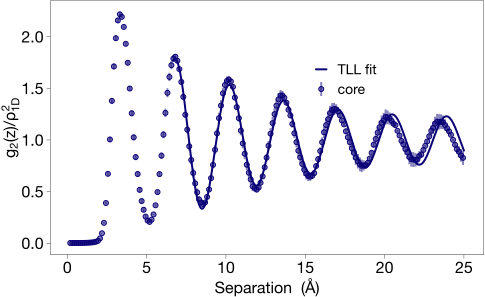

In [10]:
def plot_g2z_core(_ax):

    _ax.errorbar(r_core[1:]+Δr_core/2,g2_core[:-1], yerr=Δg2_core[:-1], **pore.get_props(core_color), label='core')
    _z = np.linspace(z_start,25,1000)

    fit_label = f'LL fit:  $\chi^2 = {result.redchi:.2f}$'
    fit_label = 'TLL fit'
    if model_idx == 'T0L':
        _ax.plot(_z,fit_model[model_idx](_z,ρ0,L,result.params['K'].value,result.params['A'].value), 
             color=core_color, zorder=-10, label=fit_label)
    elif model_idx == 'T0Linf':
        _ax.plot(_z,fit_model[model_idx](_z,ρ0,result.params['K'].value,result.params['A'].value), 
             color=core_color, zorder=-10, label=fit_label)
    elif model_idx == 'TL':
        _ax.plot(_z,pore.g2_LL_TL(_z,ρ0,L,T,result.params['K'].value,result.params['v'].value,result.params['A'].value), 
                 color=core_color, zorder=-10, label=fit_label)

    _ax.set_xlabel('Separation  (Å)')
    _ax.set_ylabel(r'$g_2(z)/\rho_{\rm 1D}^2$')
    _ax.legend(loc=(0.6,0.6), handlelength=0.75);
    #plt.savefig('../figures/g2_core.pdf');
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_g2z_core(ax)

### Plot the full z-projected correlation function

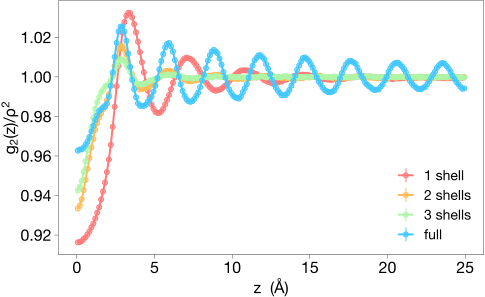

In [11]:
def plot_g2z_pore(_ax):

    for i,cμ in enumerate(μ):
        ckey = f'μ = {cμ} K'
        r_cyl,g2_cyl,Δg2_cyl = data_cyl['g2'][ckey]
        Δr_cyl = r_cyl[2]-r_cyl[1]
        plt.errorbar(r_cyl+Δr_cyl/2,g2_cyl, yerr=Δg2_cyl, **pore.get_props(pore_colors[ckey], ls='-'), label=pore_labels[ckey])

    _ax.set_xlabel('z  (Å)')
    _ax.set_ylabel(r'$g_2(z)/\rho^2$')
    #ax.set_ylim(0,2.5)
    _ax.legend(handlelength=1);
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_g2z_pore(ax)

### Plot the full spherical averaged pair correlation function

#### plot_g2r_pore

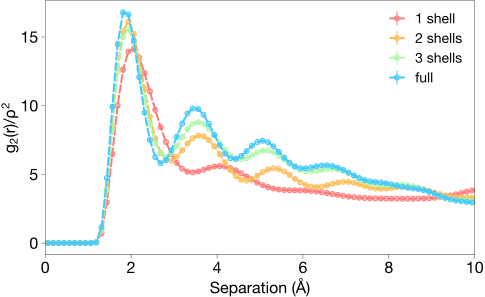

In [12]:
def plot_g2r_pore(_ax):

    for i,cμ in enumerate(μ):
        ckey = f'μ = {cμ} K'
        r_full,g2_full,Δg2_full = data['g2'][ckey]
        Δr_full = r_full[2]-r_full[1]
        _ax.errorbar(r_full+Δr_full/2,g2_full, yerr=Δg2_full, **pore.get_props(pore_colors[ckey], ls='--'), label=pore_labels[ckey])

    _ax.set_xlabel('Separation (Å)')
    _ax.set_ylabel(r'$g_2(r) / \rho^2$')
    _ax.set_xlim(0,10)
    _ax.legend();
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_g2r_pore(ax)

## Static Structure Factor

### Core Static Structure Factor
#### plot_SQ_core

We first examine only the central core of the full pore

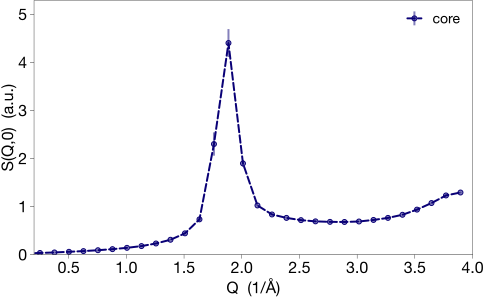

In [13]:
def plot_SQ_core(_ax):
    
    ckey = 'μ = -7.0 K'
    q_core,S_core,ΔS_core = data_1d['S'][ckey]
    
    _ax.errorbar(q_core,S_core,yerr=ΔS_core,**pore.get_props(core_color,ls='--'), label='core')
    SQmax = np.max(S_core[np.where(q_core>1)])
    
    _ax.set_ylim(0.0,1.2*SQmax)
    _ax.set_xlim(0.2,4)
    _ax.set_xlabel('Q  (1/Å)')
    _ax.set_ylabel('S(Q,0)  (a.u.)')
    _ax.legend(handlelength=1.0);
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_SQ_core(ax)

In [ ]:
q,S,ΔS = data_1d['S']['μ = -7.0 K']
np.savez('rho1d',q=q,S=S,ΔS=ΔS)

### Full Static Structure Factor

In [14]:
pimcids_ssfq = ['b3519e17-4826-41ae-9cb0-36ca785ade26','8b946b82-9c70-44af-b96d-3898318849ec',
                'f74c1fa9-6b27-4a24-920a-891ff412ea1f','64a7495d-d6fc-4c50-996d-9139f8403gpu']
data_dir_ssfq = '../data/QMC/SSF/'

In [15]:
data_ssfq,par_map_ssfq = get_data(pimcids_ssfq, data_dir_ssfq, perform_reduce=reduce)

no pair correlation function found
no static structure factor found
no pair correlation function found
no static structure factor found
no pair correlation function found
no static structure factor found
no pair correlation function found
no static structure factor found


In [16]:
def q_binning(par,data_dir):
    sim_params = {'τ':par['Specified Imaginary Time Step'],  'L':par['Container Length'], 'pimcid':par['PIMCID'], 
                 'canonical':par['Ensemble']=='canonical'}
    
    if not sim_params['canonical']:
        sim_params['μ'] = par['Chemical Potential']
    
    ssfq_file = f"{data_dir}{pimchelp.get_reduce_name(**sim_params,reduce='T', estimator='ssfq')}"

    with open(ssfq_file) as f:
        estinf = f.readline().rstrip()
        
    # find the location of the first q-vector, delineated by (q1,..,qNDIM)
    # and split into a list of q-vectors
    q_values = estinf[estinf.find("(")-1:].split()
    NDIM = len(q_values[0].rstrip(")").lstrip("(").split(","))

    # Get all the q-values and store them in an array
    q = np.zeros([len(q_values),NDIM])
    q_mags = np.zeros(len(q_values))
    q_idx = np.zeros(len(q_values), dtype=int)
    
    # Δq is hard-coded for now, I need a better way to deal with this!
    Δq = 2*π/sim_params['L']
    for n,cq in enumerate(q_values):
        _cq = cq.rstrip(")").lstrip("(").split(",")
        _cq = np.array([float(qval) for qval in _cq])
        q[n,:] = np.array([float(qval) for qval in _cq])
        q_mags[n] = np.linalg.norm(_cq)
        q_idx[n] = np.floor(q_mags[n]/(Δq-1E-6))

    # We only care about the unique q-magnitudes
    q_values = np.unique(q_mags.round(decimals=6))
    unique, q_counts = np.unique(q_idx, return_counts=True)
    
    return q_idx,q_counts,q_values

#### plot_SQ_pore

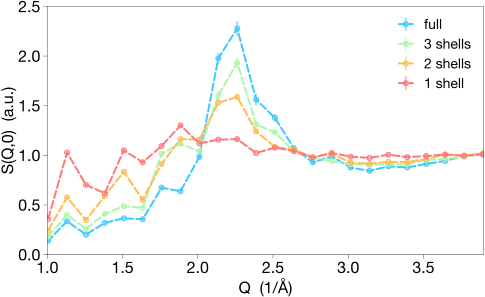

In [17]:
def plot_SQ_pore(_ax):

    for i,pimcid in enumerate(pimcids_ssfq):
        cμ = par_map_ssfq[pimcid]['Chemical Potential']
        ckey = f'μ = {cμ} K'
        q_idx,q_counts,q_values = q_binning(par_map_ssfq[pimcid],data_dir_ssfq)

        S = np.zeros_like(q_values)
        ΔS = np.zeros_like(q_values)

        q,_S,_ΔS = data_ssfq['Sq'][ckey]

        for n,__S in enumerate(_S):
            S[q_idx[n]] += __S
            ΔS[q_idx[n]] += _ΔS[n]**2

        S /= q_counts
        ΔS /= q_counts
        ΔS = np.sqrt(ΔS)
        SQmax = np.max(S[np.where(q_values>1)])

        # store the averaged processed S(Q) in the data dictionary
        data_ssfq['Sqave'][ckey] = q_values,S,ΔS
        _ax.errorbar(q_values,S,yerr=ΔS, **pore.get_props(pore_colors[ckey], ls='--'), label=pore_labels[ckey])

    _ax.set_ylim(0.0,2.5)
    _ax.set_xlim(1,3.9)
    _ax.set_xlabel('Q  (1/Å)')
    _ax.set_ylabel('S(Q,0)  (a.u.)')
    _ax.legend(handlelength=1); 
    
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_SQ_pore(ax)

### Experimental Scattering Figure

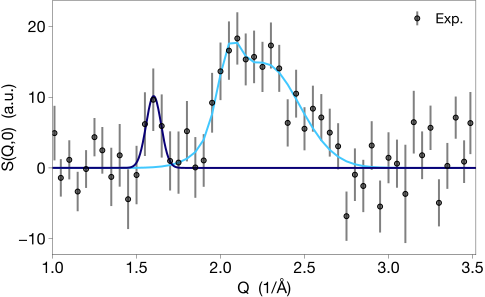

In [18]:
def plot_SQ_exp(_ax):
    _Q,_S,_ΔS,layer_fit,core_fit = np.loadtxt('../data/SQ_experiment.dat', unpack=True)
        
    _ax.errorbar(_Q,_S,_ΔS, **pore.get_props('#000000'), label='Exp.')
    
    _ax.plot(_Q,layer_fit, color=lblue)
    
    # parameters for the fit to the core peak from DAVE
    Q_fit = np.linspace(0,4,1000)
    A = 10.147
    C = 1.602
    σ = 0.06298
    S_core_fit = A*np.exp(-(Q_fit-C)**2/σ**2)
    
    #_ax.plot(_Q,core_fit, color=core_color)
    _ax.plot(Q_fit,S_core_fit, color=core_color)


    #_ax.set_ylim(,2.5)
    _ax.set_xlim(1,3.52)
    _ax.set_xlabel('Q  (1/Å)')
    _ax.set_ylabel('S(Q,0)  (a.u.)')
    _ax.legend(); 
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    plot_SQ_exp(ax)

## Create the Combined Figure

[3.4039, 2.10373]


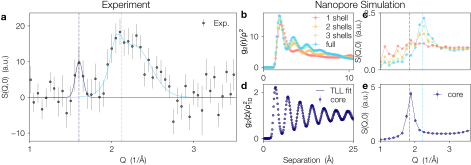

In [19]:
with plt.style.context(plot_style['sans']):
    figsize = plt.rcParams['figure.figsize']
    print(figsize)
    dgutils.fonts.set_custom_font(font_path)
    fig = plt.figure(figsize=(2.25*figsize[0],1.1*figsize[1]), constrained_layout=False)
    axd = fig.subplot_mosaic(
    [
        ["exp","exp","full_g2","full_SQ"],
        ["exp","exp","core_g2","core_SQ"]
    ], 
        gridspec_kw={
#         "bottom": 0.25,
#         "top": 0.95,
#         "left": 0.1,
#         "right": 0.5,
          "wspace": 0.3,
         "hspace": 0.25,
     },
    )
    
    plot_SQ_exp(axd["exp"])
    
    plot_g2r_pore(axd["full_g2"])
    plot_SQ_pore(axd["full_SQ"])
    plot_g2z_core(axd["core_g2"])
    plot_SQ_core(axd["core_SQ"])

    
    axd["core_g2"].set_xlim(0,25)
    axd["core_g2"].legend(loc=(0.55,0.6), labelspacing=0.2)
    
    axd["full_g2"].set_xlabel("")
    axd["full_g2"].set_xlim(0,10.5)
    axd["full_g2"].legend(loc=(0.5,0.32), labelspacing=0.2)

    #axd["core_SQ"]._shared_x_axes.join(axd["core_SQ"], axd["full_SQ"])
    axd["core_SQ"].set_xlim(1,3.6)
    axd["full_SQ"].set_xlim(1,3.6)

    axd["full_SQ"].xaxis.set_visible(False)
    axd["full_SQ"].get_legend().remove()
    
    axd['core_SQ'].axvline(x=2*π*ρ0, color=core_color, zorder=-100, alpha=0.8, ls='-',dashes=(8, 4))
    axd['full_SQ'].axvline(x=2*π*ρ0, color=core_color, zorder=-100, alpha=0.8, ls='-',dashes=(8, 4))
    
    axd['exp'].axvline(x=1.6, color=core_color, zorder=-100, alpha=0.8, ls='-',dashes=(8, 4))
    axd['exp'].axvline(x=2*π*(1.0/2.96), color=lblue, zorder=-100, alpha=0.8, ls='-',dashes=(8, 4))

    axd['core_SQ'].axvline(x=2*π*(1.0/2.84), color=lblue, zorder=-100, alpha=0.8, ls='-',dashes=(8, 4))
    axd['full_SQ'].axvline(x=2*π*(1.0/2.84), color=lblue, zorder=-100, alpha=0.8, ls='-',dashes=(8, 4))

    fig.text(0.325,0.95,'Experiment', ha='center')
    fig.text(0.75,0.95,'Nanopore Simulation', ha='center')
    
    # add panel labels
    font_props = dgutils.fonts.get_custom_font_props(pore.bold_font_path)
    axd['exp'].text(-0.14,1.0,'a', ha='left',va='top', transform=axd['exp'].transAxes, fontproperties=font_props)
    axd['full_g2'].text(-0.25,1.04,'b', ha='left',va='top', transform=axd['full_g2'].transAxes,fontproperties=font_props)
    axd['full_SQ'].text(-0.2,1.04,'c', ha='left',va='top', transform=axd['full_SQ'].transAxes, fontproperties=font_props)
    axd['core_g2'].text(-0.25,1.04,'d', ha='left',va='top', transform=axd['core_g2'].transAxes, fontproperties=font_props)
    axd['core_SQ'].text(-0.2,1.04,'e', ha='left',va='top', transform=axd['core_SQ'].transAxes, fontproperties=font_props)

    plt.savefig('../figures/SQ_exp_theory.pdf')


In [20]:
1.6/(2*π)

0.25464790894703254

In [ ]:
2*π*ρ0

In [ ]:
1.0/2.84

In [ ]:
1.6/(2*π)

In [ ]:
N =10
fig, ax = plt.subplots(figsize=(16,6))
ax.axis('off')

for n in range(N):
    x = np.sin(np.linspace(0,2*np.pi,(n+1)*10))
    ax.imshow([x, x], extent=(0, 2*np.pi, n, n+1), aspect='auto')
ax.autoscale()
ax.invert_yaxis()

In [ ]:
from heprops import helium,potential


In [ ]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_x_axes.join(target, ax)
        if sharey:
            target._shared_y_axes.join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

## Estimating the Luttinger Velocity *v*

In [ ]:
import scipy.constants as const
ħ = const.hbar
kB = const.k
mHe = const.m_u*4.003

For a Galilean-invariant system, the LL velocity can be computed from:

$$ \frac{\hbar v}{k_{\rm B}} = \frac{\hbar^2 \pi \rho_0}{K m k_{\rm B}} $$

where the result can then be converted to the desired units of ÅK.

In [ ]:
vLL = ħ**2/(mHe*kB)*π*ρ0*1E20/0.3
print(f'v = {vLL:.2f} Å K')

Using experimentally determined values:

In [ ]:
vLL = ħ**2/(mHe*kB)*(0.8/1.18)*1E20
print(f'v = {vLL:.2f} Å K')

This sets the temperature below which we might expect LL behavior to be: 

\begin{equation}
T \ll \frac{\hbar v}{k_{\rm B}} (2 k_{\rm F})
\end{equation}

In [ ]:
print(f'T = {vLL*2*0.8:.1f}')

## Auxiliary Functions and Data Exploration

### Compute the Static Structure Factor from the 1D Fourier Transform

In [ ]:
q_1d = 2*π*np.fft.rfftfreq(r_core.size,Δr_core)

# Equilibrium Structure factor
S_1d = (1.0 + ρ0*np.fft.rfft(g2_core-1.0)).real
S_1d[0] = 1E-16

### Compute the Static Structure Factor from the 3D Averaged Fourier Transform

In [ ]:
from scipy.integrate import simps
def K(k,r,g,ρ):
    return 4*π*ρ*(r*np.sin(k*r)/k)*(g)
  
q_3d = np.linspace(0.0,4.0,100)
S_3d = np.zeros_like(q_3d)
S_3d[0] = N
for i,cq in enumerate(q_3d):
    if i > 0:
        S_3d[i] = 1+ simps(K(cq,r,g2,ρ),r)

In [ ]:
plt.plot(q_1d,S_1d, '-o', ms=4, label='1D FFT')

q_core,S_core,ΔS_core = data_1d['S']['μ = -7.0 K']
plt.plot(q_core,S_core, '-o', ms=4, label='Central Core μ = -7 K', color=colors[-1], lw=1.5)
plt.axvline(x=2*π*ρ0, color='grey')

plt.legend()
plt.xlim(1,4)
plt.ylim(-1,8)

plt.xlabel('Q  (1/Å)')
plt.ylabel('S(Q)  (a.u.)')

In [ ]:
5.41/6.55

In [ ]:
1/15


In [ ]:
14/15/3

In [ ]:
0.07*151aa